In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
import pandas as pd
import re
import pickle
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

In [2]:
images = []
angles = []
samples = []
correction = 0.25 # this is a parameter to tune
def readFromDir(dir_name, if_windows):
    if if_windows:
        split_str = '\\'
    else:
        split_str = '/'
    data_pd = pd.read_csv(dir_name+'/driving_log.csv', header=None)
    lines = data_pd.values
    for line in lines:
        center_image = dir_name+'/IMG/'+line[0].split(split_str)[-1]
        left_image = dir_name+'/IMG/'+line[1].split(split_str)[-1]
        right_image = dir_name+'/IMG/'+line[2].split(split_str)[-1]
#         center_image = cv2.imread(name)
        center_angle = float(line[3])
#         images.append(center_image)
#         angles.append(center_angle)
        samples.append((center_image, center_angle))
        samples.append((left_image, center_angle+correction))
        samples.append((right_image, center_angle-correction))
print("Done")

Done


In [3]:
# get all images and angles in center 
behavior1 = '../behavior/behavior1'
behavior2 = '../behavior/behavior2' 
behavior3 = '../behavior/behavior3'
readFromDir(behavior1, if_windows=True)
readFromDir(behavior2, if_windows=True)
readFromDir(behavior3, if_windows=False)
# print(len(images))
print(len(angles))
# print(images[0].shape)
print(len(samples))
print(samples[0])

0
42351
('../behavior/behavior1/IMG/center_2017_12_16_11_41_39_478.jpg', 0.0)


float64
(42351,)



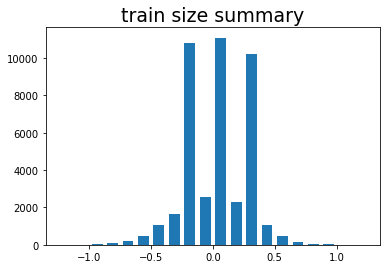

In [4]:
y_train = np.array(samples)[:,1]
y_train = y_train.astype(float)
print(y_train.dtype)
print(y_train.shape)
hist, bins = np.histogram(y_train, bins=20)
print()
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title(r'train size summary', fontsize=19)
plt.savefig("train_size.jpg", bbox_inches='tight', pad_inches=0)
plt.show()

In [5]:
# X_array = np.array(images)
# y_array = np.array(angles)
# X_, y_ = shuffle(X_array, y_array)

# X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# data_file = "data.p"
# data_var = {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}

# with open(data_file, mode='wb') as f:
#     pickle.dump(data_var, f)

In [6]:
# transform x y direction, input original rgb image
def transform_image(image, angle):
    trans_range = 150
    tx = trans_range*(np.random.uniform()-0.5)
    ty = 10*(np.random.uniform()-0.5)
    angle = angle + tx/trans_range*0.5  # max adjust angle 0.5
    rows,cols,_ = image.shape
    M = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image,M,(cols,rows))
    return image,angle

# Horizontal Flip
def flip_image(image, angle):
    # Horizontal Flip
    image = cv2.flip(image, 1)
    return image, -angle

# adjust brightness
def bright_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = v.astype(np.float)
    v *= (np.random.uniform()+0.2)
    v[v>255] = 255
    v[v<0] = 0
    v = v.astype(np.uint8)
    final_hsv = cv2.merge((h, s, v))
    image_hsv = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return image_hsv

# input rgb image
def preprocess_image(image):
    rows,cols,_ = image.shape
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image = cv2.equalizeHist(image)
    image = image[50:rows-20, 0:cols]
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    image = image/255.0 - 0.5
#     image = np.expand_dims(image, axis=2)
    return image


In [ ]:
samples = shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

def generator_train(samples, batch_size=32):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
#                 center_image = cv2.imread(name)
                image = np.asarray(Image.open(name))
                angle = float(batch_sample[1])
                image, angle = transform_image(image, angle)
                if np.random.choice([True, False]):
                    image, angle = flip_image(image, angle)
                image = bright_image(image)
                image = preprocess_image(image)
                images.append(image)
                angles.append(angle)

            # trim image to only see section with road
            X_ = np.array(images)
            y_ = np.array(angles)
            yield sklearn.utils.shuffle(X_, y_)

            
def generator_valid(samples, batch_size=32):
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
#                 center_image = cv2.imread(name)
                image = np.asarray(Image.open(name))
                angle = float(batch_sample[1])
                image = preprocess_image(image)
                images.append(image)
                angles.append(angle)

            # trim image to only see section with road
            X_ = np.array(images)
            y_ = np.array(angles)
            yield sklearn.utils.shuffle(X_, y_)            

# compile and train the model using the generator function
train_generator = generator_train(train_samples, batch_size=32)
validation_generator = generator_valid(validation_samples, batch_size=32)

33880
8471


In [ ]:
import pickle
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import Lambda, Concatenate
from keras.layers import Cropping2D, Input
from keras.layers import Reshape
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K
from keras.optimizers import SGD, Adam, RMSprop
import tensorflow
import cv2

lamda_w = 1e-4

# model = Sequential()
input1 = Input(shape=(64, 64, 3))
         
conv1 = Conv2D(16, (1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(lamda_w))(input1)
conv1 = Activation('elu')(conv1)
conv1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv1)

conv2 = Conv2D(32, (5, 5), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(lamda_w))(conv1)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv2)

conv3 = Conv2D(32, (1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(lamda_w))(conv2)
conv3 = Activation('elu')(conv3)

conv4 = Conv2D(64, (5, 5), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(lamda_w))(conv3)
conv4 = Activation('elu')(conv4)
conv4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(conv4)

conv5 = Conv2D(64, (1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(lamda_w))(conv4)
conv5 = Activation('elu')(conv5)

merge1 = Concatenate()([conv4, conv5])
flat1 = Flatten()(merge1)
flat1 = Dropout(0.5)(flat1)

dense1 = Dense(128, kernel_regularizer=regularizers.l2(lamda_w))(flat1)
dense1 = Activation('elu')(dense1)
dense1 = Dropout(0.5)(dense1)

output = Dense(1)(dense1)

model = Model(inputs=input1, outputs=output)

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mse', optimizer=adam)
model.summary()

filepath="model-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), \
                                     validation_data=validation_generator, \
                                     nb_val_samples=len(validation_samples), \
                                     nb_epoch=10, verbose=1, callbacks=callbacks_list)
model.save('model.h5') 

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

/home/tzyhpcom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/tzyhpcom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=33880, epochs=10, validation_steps=8471)`


Epoch 1/10
33880/33880 [==============================] - 5668s 167ms/step - loss: 0.0430 - val_loss: 0.0261
Epoch 2/10
33880/33880 [==============================] - 5664s 167ms/step - loss: 0.0299 - val_loss: 0.0233
Epoch 3/10
33880/33880 [==============================] - 5661s 167ms/step - loss: 0.0280 - val_loss: 0.0208
Epoch 4/10
33880/33880 [==============================] - 5664s 167ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 5/10
 1222/33880 [>.............................] - ETA: 1:20:51 - loss: 0.0268

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt

# image1 = cv2.imread(samples[0][0])
# image2 = Image.open(samples[0][0])
# plt.figure()
# plt.imshow(image1)
# plt.figure()
# plt.imshow(image2)

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

# history_object = model.fit_generator(train_generator, samples_per_epoch =
#     len(train_samples), validation_data = 
#     validation_generator,
#     nb_val_samples = len(validation_samples), 
#     nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig("loss.jpg", bbox_inches='tight', pad_inches=0)
plt.show()